# Required Packages

In [3]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now
%matplotlib inline

# Extracting text

In [5]:
# since we're working in python 2.7 in this tutorial, we need to make sure to clean our data to make it unicode consistent
def clean(text):
    (''.join([i if ord(i) < 128 else ' ' for i in text]))

test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'
text = open(lee_train_file).read()

In [8]:
text

'Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year\'s Eve in New South Wales, fire crews have been called to new fire at Gunning, south of Goulburn. While few details are available at th

# Pre-Processing Data

In [17]:
import spacy
from spacy.en import English
nlp = spacy.load("en_core_web_sm")

In [18]:
my_stop_words = [u'say', u'\'s', u'Mr', u'be', u'said', u'says', u'saying']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [20]:
doc = nlp((text))

In [21]:
doc

Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year's Eve in New South Wales, fire crews have been called to new fire at Gunning, south of Goulburn. While few details are available at this

In [22]:
# we add some words to the stop word list
texts, article = [], []
for w in doc:
    # if it's not a stop word or punctuation mark, add it to our article!
    if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
        # we add the lematized version of the word
        article.append(w.lemma_)
    # if it's a new line, it means we're onto our next document
    if w.text == '\n':
        texts.append(article)
        article = []

In [23]:
texts

[['hundred',
  'people',
  'force',
  'vacate',
  'home',
  'Southern',
  'Highlands',
  'New',
  'South',
  'Wales',
  'strong',
  'wind',
  'today',
  'push',
  'huge',
  'bushfire',
  'town',
  'Hill',
  'new',
  'blaze',
  'near',
  'Goulburn',
  'south',
  'west',
  'Sydney',
  'force',
  'closure',
  'Hume',
  'Highway',
  '4:00pm',
  'aedt',
  'marked',
  'deterioration',
  'weather',
  'storm',
  'cell',
  'move',
  'east',
  'Blue',
  'Mountains',
  'force',
  'authority',
  'decision',
  'evacuate',
  'people',
  'home',
  'outlying',
  'street',
  'Hill',
  'New',
  'South',
  'Wales',
  'southern',
  'highland',
  'estimated',
  'resident',
  'leave',
  'home',
  'nearby',
  'Mittagong',
  'New',
  'South',
  'Wales',
  'Rural',
  'Fire',
  'Service',
  'weather',
  'condition',
  'cause',
  'fire',
  'burn',
  'finger',
  'formation',
  'ease',
  'fire',
  'unit',
  'Hill',
  'optimistic',
  'defend',
  'property',
  'blaze',
  'burn',
  'New',
  'Year',
  'Eve',
  'New',


In [24]:
bigram = gensim.models.Phrases(texts)

In [25]:
texts = [bigram[line] for line in texts]

In [26]:
texts[10]

['Work',
 'continue',
 'morning',
 'restore',
 'power',
 'supply',
 'ten',
 'thousand',
 'home',
 'black',
 'wild',
 'storm',
 'strike',
 'south',
 'east',
 'Queensland',
 'night',
 'gale',
 'force',
 'wind',
 'uproot',
 'tree',
 'bring',
 'power',
 'line',
 'damaging',
 'home',
 'car',
 'Energex',
 'Ergon',
 'energy',
 'available',
 'person',
 'work',
 'night',
 'restore',
 'power',
 'location',
 'Brisbane',
 'west',
 'Toowoomba',
 'north',
 'Sunshine',
 'Coast',
 'Boonah',
 'south_west',
 'Brisbane',
 'protective',
 'tarpaulin',
 'rip',
 'home',
 'undergo',
 'repair',
 'follow',
 'severe',
 'storm',
 'Christmas',
 'Nambour',
 'people',
 'rescue',
 'high',
 'voltage',
 'power',
 'line',
 'fall',
 'car',
 'trap',
 'inside',
 'landsborough',
 'fierce',
 'wind',
 'send',
 'large',
 'tree',
 'crash',
 'house',
 'injure']

In [27]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [28]:
corpus[100]

[(182, 1),
 (201, 2),
 (266, 1),
 (285, 1),
 (286, 1),
 (427, 1),
 (508, 1),
 (551, 1),
 (633, 1),
 (708, 1),
 (894, 1),
 (1022, 2),
 (1240, 1),
 (1402, 1),
 (1438, 2),
 (1651, 1),
 (1658, 1),
 (1696, 1),
 (1697, 1),
 (1785, 3),
 (1986, 1),
 (2017, 2),
 (2076, 1),
 (2098, 1),
 (2103, 1),
 (2113, 1),
 (2797, 2),
 (2857, 1),
 (2915, 3),
 (3021, 1),
 (3178, 1),
 (3179, 1),
 (3180, 1),
 (3181, 1),
 (3182, 1),
 (3183, 1),
 (3184, 1),
 (3185, 1),
 (3186, 1),
 (3187, 1),
 (3188, 1),
 (3189, 1),
 (3190, 1),
 (3191, 1),
 (3192, 1),
 (3193, 1),
 (3194, 1),
 (3195, 1),
 (3196, 1),
 (3197, 1),
 (3198, 1),
 (3199, 1),
 (3200, 1),
 (3201, 1),
 (3202, 1)]

# LSI MODEL
LSI stands for Latent Semantic Indeixing - it is a popular information retreival method which works by decomposing the original matrix of words to maintain key topics. Gensim's implementation uses an SVD.

In [29]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [30]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics

[(0,
  '0.239*"israeli" + 0.214*"Arafat" + 0.196*"palestinian" + 0.175*"force" + 0.159*"kill" + 0.159*"official" + 0.151*"attack" + 0.141*"people" + 0.118*"day" + 0.117*"Israel"'),
 (1,
  '0.312*"israeli" + 0.300*"Arafat" + 0.269*"palestinian" + -0.162*"Afghanistan" + 0.161*"Sharon" + -0.159*"Australia" + 0.154*"Israel" + 0.127*"Hamas" + 0.122*"West_Bank" + -0.116*"day"'),
 (2,
  '0.261*"Afghanistan" + 0.222*"force" + 0.186*"Al_Qaeda" + 0.176*"bin_Laden" + -0.171*"fire" + 0.143*"Pakistan" + 0.140*"Taliban" + -0.139*"Sydney" + 0.135*"fighter" + 0.132*"Tora_Bora"'),
 (3,
  '-0.379*"fire" + -0.273*"area" + -0.207*"Sydney" + 0.204*"Australia" + -0.175*"firefighter" + -0.161*"north" + -0.152*"wind" + -0.138*"Wales" + -0.138*"New_South" + -0.131*"south"'),
 (4,
  '0.276*"company" + 0.207*"Qantas" + 0.180*"union" + -0.169*"test" + 0.148*"worker" + -0.140*"win" + -0.137*"match" + -0.132*"South_Africa" + -0.119*"wicket" + 0.116*"cent"')]

# HDP MODEL
HDP, the Hierarchical Dirichlet process is an unsupervised topic model which figures out the number of topics on it's own.

In [31]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [32]:
hdpmodel.show_topics()

[(0,
  '0.003*group + 0.003*palestinian + 0.003*Government + 0.002*Sharon + 0.002*choose + 0.002*kill + 0.002*militant + 0.002*dominance + 0.002*Hamas + 0.002*security + 0.002*terrorism + 0.002*suicide_attack + 0.001*attack + 0.001*Gaza_Strip + 0.001*Arafat + 0.001*israeli + 0.001*call + 0.001*human_right + 0.001*target + 0.001*television'),
 (1,
  '0.003*match + 0.002*team + 0.002*Rafter + 0.002*play + 0.002*israeli + 0.002*ask + 0.002*entire + 0.002*Australia + 0.002*guarantee + 0.002*France + 0.001*victory + 0.001*tennis + 0.001*kill + 0.001*Wayne + 0.001*final + 0.001*win + 0.001*Rural_Fire + 0.001*day + 0.001*decide + 0.001*hour'),
 (2,
  '0.003*agreement + 0.002*Afghanistan + 0.002*Virgin + 0.002*afghan + 0.002*talk + 0.002*Launceston + 0.002*Senator_Hill + 0.002*day + 0.002*call + 0.002*structure + 0.002*terminal + 0.002*flight + 0.002*morning + 0.002*time + 0.001*troop + 0.001*australian + 0.001*unfurl + 0.001*month + 0.001*temporary + 0.001*lunchtime'),
 (3,
  '0.004*israeli +

# LDA MODEL
LDA, or Latent Dirichlet Allocation is arguably the most famous topic modelling algorithm out there. Out here we create a simple topic model with 10 topics.

In [33]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [34]:
ldamodel.show_topics()

[(0,
  '0.007*"fire" + 0.004*"area" + 0.004*"today" + 0.004*"Wales" + 0.004*"day" + 0.004*"Sydney" + 0.004*"israeli" + 0.004*"Australia" + 0.003*"wind" + 0.003*"home"'),
 (1,
  '0.006*"year" + 0.005*"day" + 0.005*"force" + 0.004*"Australia" + 0.004*"tell" + 0.004*"report" + 0.003*"company" + 0.003*"know" + 0.003*"test" + 0.003*"Afghanistan"'),
 (2,
  '0.006*"people" + 0.005*"israeli" + 0.004*"palestinian" + 0.004*"Israel" + 0.004*"Hamas" + 0.003*"change" + 0.003*"force" + 0.003*"call" + 0.003*"hour" + 0.003*"come"'),
 (3,
  '0.005*"people" + 0.004*"Taliban" + 0.004*"arrest" + 0.003*"come" + 0.003*"man" + 0.003*"work" + 0.003*"Australian" + 0.003*"win" + 0.003*"metre" + 0.003*"australian"'),
 (4,
  '0.007*"Australia" + 0.005*"day" + 0.004*"force" + 0.004*"good" + 0.004*"man" + 0.004*"claim" + 0.003*"people" + 0.003*"new" + 0.003*"attack" + 0.003*"month"'),
 (5,
  '0.005*"new" + 0.004*"time" + 0.004*"Arafat" + 0.004*"people" + 0.004*"think" + 0.003*"attack" + 0.003*"Australia" + 0.003*"y

# PyLDAvis

In [36]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.027906 -0.003594       1        1  21.864258
4     -0.007968 -0.052006       2        1  13.462562
1      0.055701 -0.016650       3        1  12.333730
5      0.011898 -0.009648       4        1  11.987821
0     -0.013815 -0.039149       5        1   8.078526
2     -0.056803  0.017547       6        1   7.612257
6      0.043761  0.041095       7        1   6.773568
9     -0.034003  0.028036       8        1   6.732524
8      0.023778 -0.002480       9        1   5.660732
3      0.005356  0.036849      10        1   5.494021, topic_info=          Term        Freq       Total Category  logprob  loglift
56        fire   69.000000   69.000000  Default  30.0000  30.0000
847    israeli   77.000000   77.000000  Default  29.0000  29.0000
311  Australia  111.000000  111.000000  Default  28.0000  28.0000
201       year   93.000000   93.000000  Default  27.0000  27.0000
325    Taliban   35.000000   35.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
128     attack    3.550694   75.992180  Topic10  -6.0999  -0.1620
22      Sydney    3.176587   48.150261  Topic10  -6.2113   0.1830
59       force    3.417145   94.984238  Topic10  -6.1383  -0.4234
221        day    3.250048   97.818237  Topic10  -6.1884  -0.5029
311  Australia    3.263277  111.944756  Topic10  -6.1843  -0.6338

[811 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
645       1  0.291589           
645       2  0.104139           
645       3  0.083311           
645       4  0.166622           
645       5  0.083311           
...     ...       ...        ...
179       6  0.048502  yesterday
179       7  0.072754  yesterday
179       8  0.024251  yesterday
179       9  0.072754  yesterday
179      10  0.048502  yesterday

[2429 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 2, 6, 1, 3, 7, 10, 9, 4])

# Topic Coherence
Topic Coherence is a new gensim functionality where we can identify which topic model is 'better'. By returning a score, we can compare between different topic models of the same. We use the same example from the news classification notebook to plot a graph between the topic models we have created.

In [37]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [38]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

In [39]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

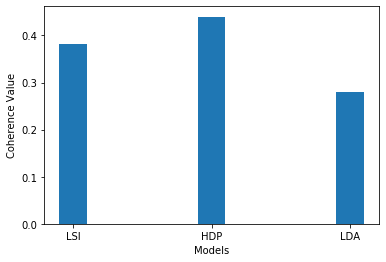

In [40]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])